In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns
from scipy import sparse
# import muon as mu
# Import a module with ATAC-seq-related functions
# from muon import atac as ac
sc.settings.verbosity =0

In [ ]:
sample_colors = {'lib_03': '#1f77b4',
 'lib_09': '#ff7f0e',
 'lib_10': '#279e68',
 'lib_15': '#d62728',
 'lib_16': '#aa40fc',
 'lib_19': '#8c564b',
 'lib_20': '#e377c2',
 'lib_23': '#686868',
 'lib_29': '#b5bd61',
 'lib_34': '#17becf',
 'lib_36': '#aec7e8',
 'lib_38': '#ffbb78',
 'lib_49': '#98df8a',
 'lib_51': '#ff9896',
 'lib_55': '#c5b0d5',
 'lib_56': '#c49c94',
 'lib_57': '#f7b6d2',
 'lib_68': '#dbdb8d',
 'lib_420': '#9edae5',
 'lib_776': '#808080'}

In [2]:
os.listdir('../CZI_scRNA_5p_Raw_Data/raw')

['HK-688', 'HK-038', 'HK-687', 'HK-036']

In [3]:
sample_code_dict = {'HK-036':'lib_36',
                   'HK-038':'lib_38',
                   'HK-688':'lib_10',
                   'HK-687':'lib_09'}

In [ ]:
import doubletdetection

for i in sample_code_dict.keys():
    adata = sc.read_10x_h5(f'../CZI_scRNA_5p_Raw_Data/raw/{i}/filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=1)
    sc.pp.filter_genes(adata, min_counts=1)
    adata.obs['sample'] = sample_code_dict[i]

    clf = doubletdetection.BoostClassifier(
        n_iters=10,n_components=30,
        clustering_algorithm="louvain",
        standard_scaling=False,
        pseudocount=1,
        n_jobs=-1,
    )
    doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
    doublet_score = clf.doublet_score()
    #f = doubletdetection.plot.convergence(clf, save=f'convergence_{i}.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

    adata.obs['doublets'] = doublets
    adata.obs['singlets'] = ~doublets.astype(bool)
    adata.obs['doublets_score'] = doublet_score
    adata.write(f'../CZI_scRNA_5p_Raw_Data/raw/{i}/Doublets_Detection.h5ad')

In [4]:
adata = []
for i in sample_code_dict.keys():
    a = sc.read_10x_h5(f'../CZI_scRNA_5p_Raw_Data/raw/{i}/filtered_feature_bc_matrix.h5')
    a.var_names_make_unique()
    a.obs['sample'] = sample_code_dict[i]
    adata.append(a)
    del a

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-pac

In [5]:
adata = adata[0].concatenate(adata[1:], join = 'outer')

In [6]:
adata

AnnData object with n_obs × n_vars = 32189 × 36601
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
sc.pp.filter_cells(adata, min_counts=1)
# sc.pp.filter_genes(adata, min_counts=1)

In [ ]:
adata.layers['counts'] = adata.X.copy()

adata.var['rb'] = adata.var_names.str.startswith("RPS", "RPL")
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb'], percent_top=None, log1p=False, inplace=True)

In [9]:
df = pd.DataFrame(adata.obs['sample'].value_counts().index, index = adata.obs['sample'].value_counts().index  , columns =[ 'samples' ])
df['n_cells'] = adata.obs['sample'].value_counts().values.astype(int)

In [10]:
list(sns.color_palette("tab20", len(adata.obs['sample'].unique())))

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764)]

<Axes: title={'center': 'Total nº of Cells'}, xlabel='samples'>

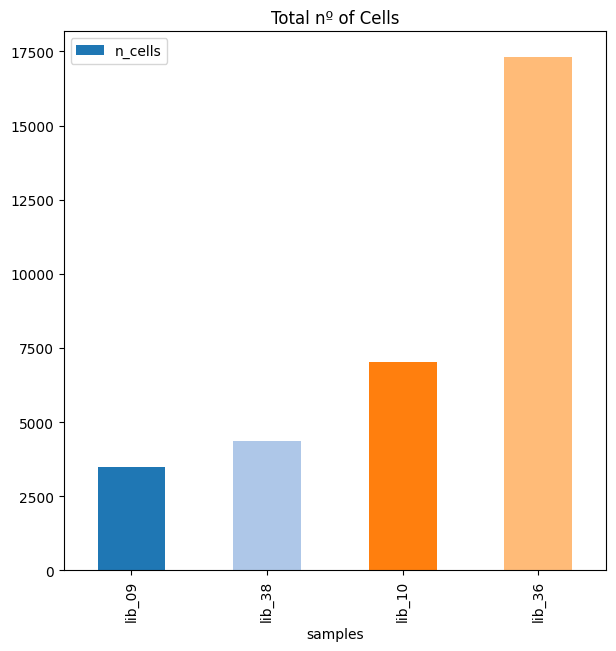

In [11]:
rcParams['figure.figsize'] = (7,7)
df.reindex(index=np.argsort(df['n_cells']).index.tolist()[::-1]).plot(kind='bar', color = list(sns.color_palette("tab20", len(adata.obs['sample'].unique()))) ,x = 'samples', y ='n_cells' , title = 'Total nº of Cells' )

In [12]:
rcParams['figure.figsize'] = (14,4)
font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 13}

plt.rc('font', **font)

In [13]:
list_val = []
list_sample = []
for i in adata.obs['sample'].unique():
    prim = adata[adata.obs['sample'].isin([i])]
    list_val.append(np.sum(prim.obs['n_genes_by_counts'])/prim.shape[0])
    list_sample.append(i)
sort_l = np.argsort(list_val)
order = [list_sample[i] for i in sort_l]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

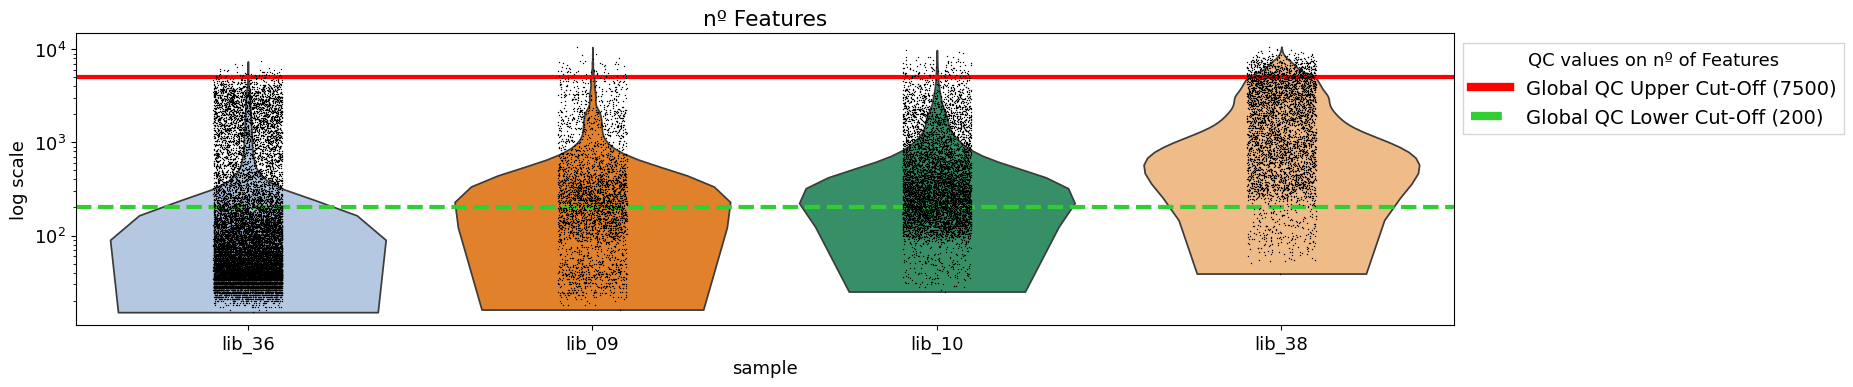

In [ ]:
a = sc.pl.violin(adata, keys = ['n_genes_by_counts'] ,show=False, log = True, groupby='sample', order = order, palette=sample_colors)
l1 = a.axhline(5000, color='red',linewidth = 3)

l2 = a.axhline(200, color='limegreen', label = '2ndQC NON-IMMUNE',linewidth = 3, linestyle = '--')
a.set_title('nº Features')
a.set_ylabel('log scale')
leg = a.legend([l1,l2],['Global QC Upper Cut-Off (7500)','Global QC Lower Cut-Off (200)'],fontsize = 14, title = 'QC values on nº of Features',
  fancybox=False, ncol=1,   bbox_to_anchor = (1,1))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'../../../figures/5p_QC_violin_n_genes_by_counts.png', bbox_inches='tight', dpi=600)


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

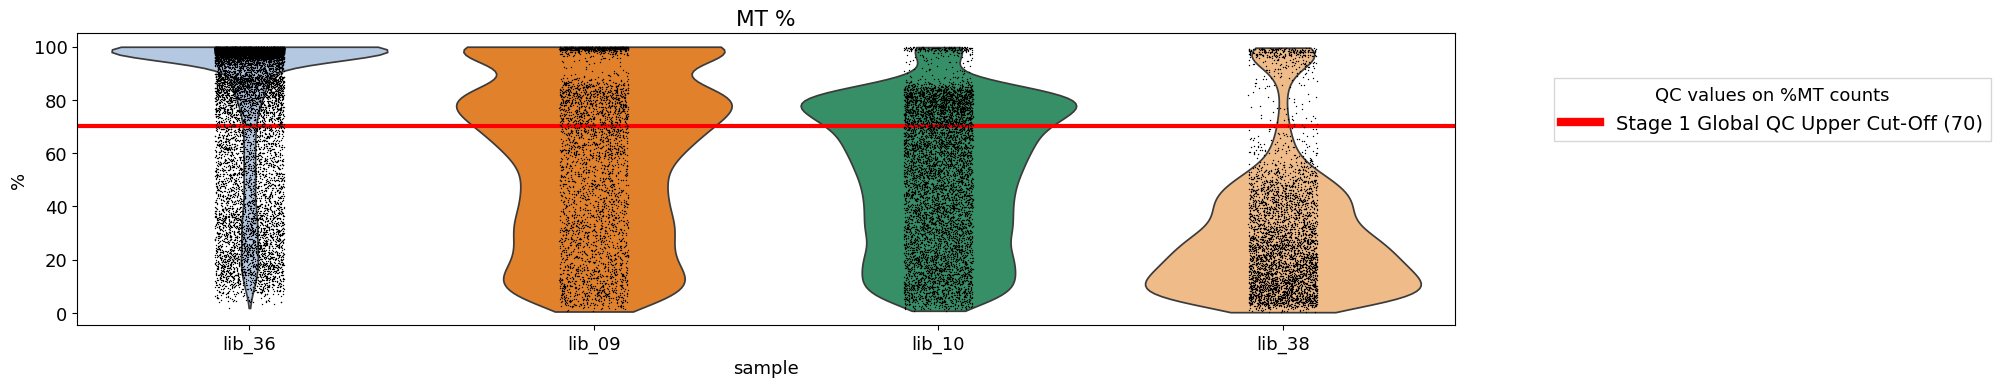

In [ ]:
a = sc.pl.violin(adata, keys = ['pct_counts_mt'] ,show=False, log = False, groupby='sample', order = order, palette=sample_colors)
a.set_title('MT %')
a.set_ylabel('%')
l1 = a.axhline(70, color='red',linewidth = 3)

leg = a.legend([l1],['Stage 1 Global QC Upper Cut-Off (70)'],loc = 'lower center',fontsize = 14, title = 'QC values on %MT counts',
  fancybox=False, ncol=1,   bbox_to_anchor = (1.23,0.6))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'../../../figures/5p_pct_counts_mt.png', bbox_inches='tight',dpi=600)


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

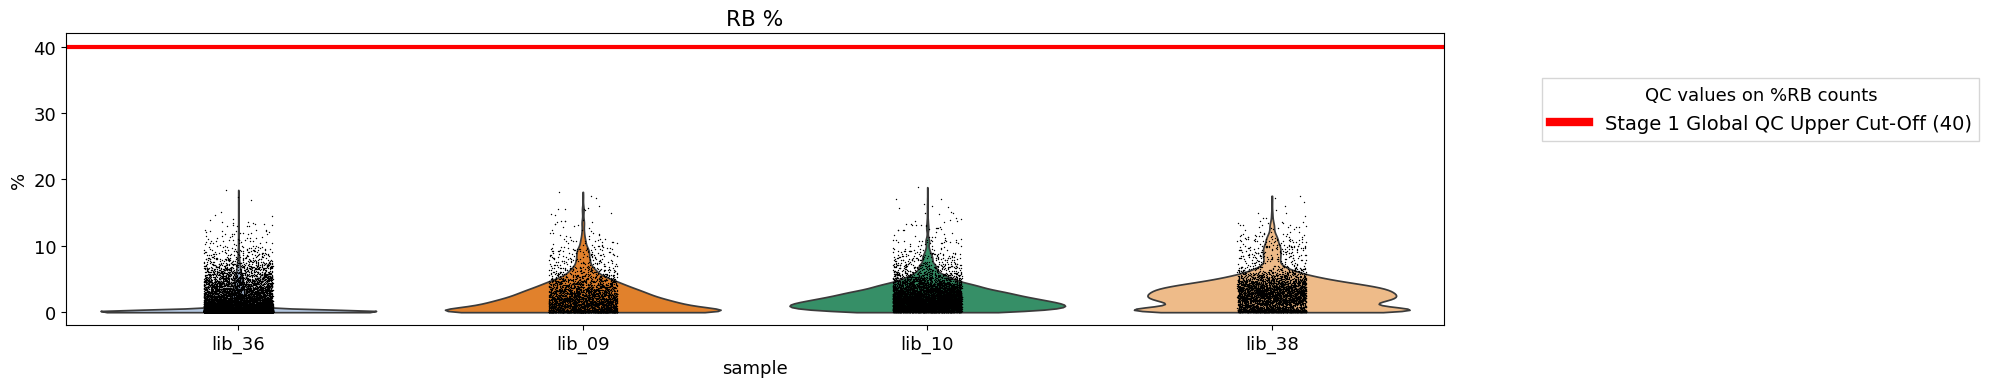

In [ ]:
a = sc.pl.violin(adata, keys = ['pct_counts_rb'] ,show=False, log = False, groupby='sample', order = order, palette=sample_colors)
l1 = a.axhline(40, color='red',linewidth = 3)

a.set_title('RB %')
a.set_ylabel('%')

leg = a.legend([l1],['Stage 1 Global QC Upper Cut-Off (40)','Stage 2 IMMUNE QC Upper Cut-Off (10)'],loc = 'lower center',fontsize = 14, title = 'QC values on %RB counts',
  fancybox=False, ncol=1,   bbox_to_anchor = (1.23,0.6))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'../../../figures/5p_pct_counts_mt.png', bbox_inches='tight',dpi=600)


In [26]:
adata

AnnData object with n_obs × n_vars = 32189 × 36601
    obs: 'sample', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'genome', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts'

In [28]:
mt_threshold = 70
rb_threshold = 40
# tc_upper_threshold = 16000
nF_lower_threshold = 200
nF_upper_threshold = 7500

In [29]:
adata = adata[adata.obs['pct_counts_mt']<mt_threshold]
adata = adata[adata.obs['pct_counts_rb']<rb_threshold]
# adata = adata[adata.obs['total_counts']<tc_upper_threshold]
adata = adata[adata.obs['n_genes_by_counts']>nF_lower_threshold]
adata = adata[adata.obs['n_genes_by_counts']<nF_upper_threshold]

In [30]:
adata.X = adata.layers['counts'].copy()

In [31]:
adata.X.data

array([ 1.,  1.,  1., ..., 17.,  4., 38.], dtype=float32)

In [32]:
sc.pp.highly_variable_genes(adata,n_top_genes=5000, flavor='seurat_v3', layer = 'counts')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [33]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marioam/miniconda3/envs/General_env/lib/python3.9/si

In [34]:
rcParams['figure.figsize'] = (12,12)

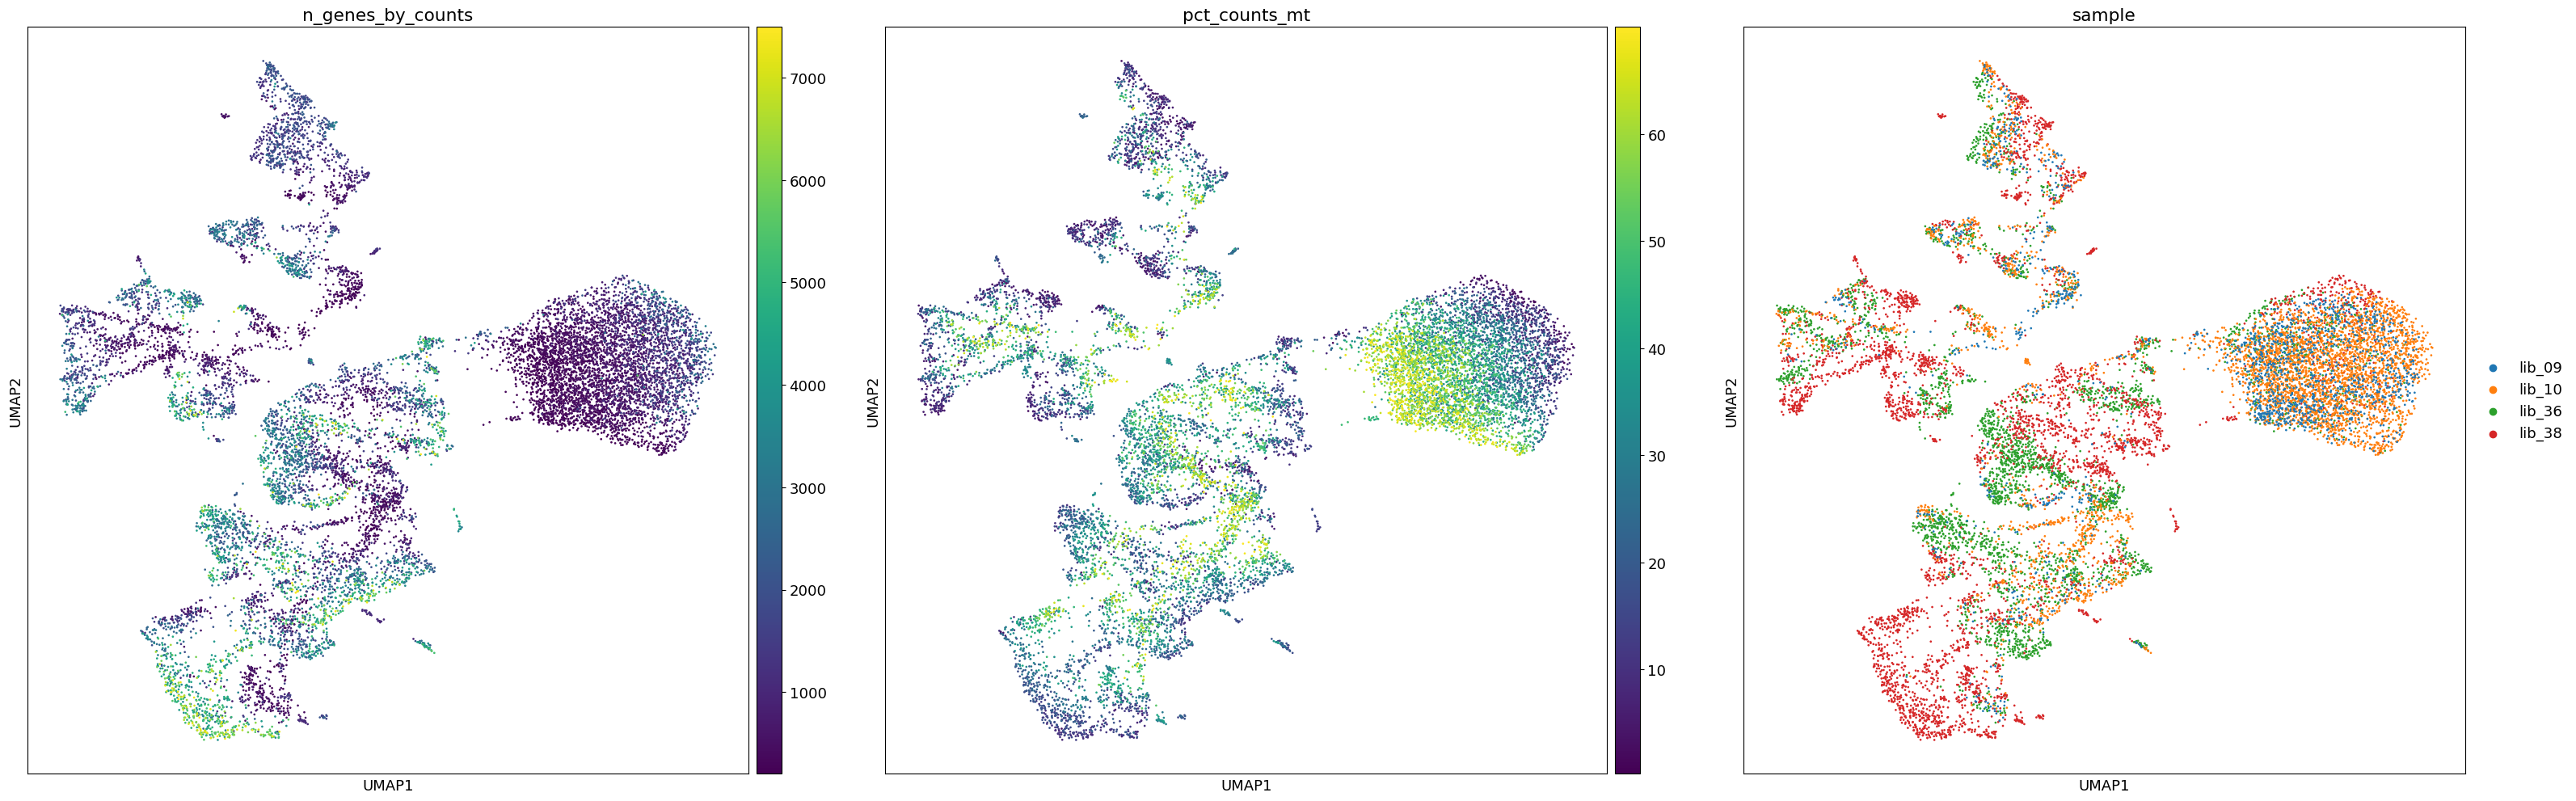

In [38]:
sc.pl.umap(adata, color=['n_genes_by_counts','pct_counts_mt','sample'], size = 15)

In [36]:
adata.write('objects/5p_merged_1stQC_raw.h5ad', compression = 'gzip')